In [1]:
from datasets.loader import load_dataset
from models.XGB.forecast import *
from sklearn.metrics import mean_squared_error

import xgboost as xgb

## Define Parameters

In [2]:
SUNSPOTS_PATH = "datasets/Sunspots.csv"

N_STEPS_IN_AR = 100
N_STEPS_IN_WINDOW = 100
N_STEPS_OUT_WINDOW = 50

## Load Dataset

### Dataset for window forecasting

In [3]:
ds_sunspots_window = load_dataset(
    ds_path=SUNSPOTS_PATH,
    n_steps_in=N_STEPS_IN_WINDOW,
    n_steps_out=N_STEPS_OUT_WINDOW,
    test_fraction=0.1
)

### Dataset for forecasting with autoregression

In [4]:
ds_sunspots_ar = load_dataset(
    ds_path=SUNSPOTS_PATH,
    n_steps_in=N_STEPS_IN_AR,
    n_steps_out=1,
    test_fraction=0.1
)

## Train XGBoost regressor

### Regressor for window regression

In [5]:
xgb_window = xgb.XGBRegressor()
xgb_window.fit(ds_sunspots_window.train_x, ds_sunspots_window.train_y)
xgb_window.save_model(f"models/XGB/saved/window_forecast_{N_STEPS_IN_WINDOW}-{N_STEPS_OUT_WINDOW}.json")

### Regressor for autoregression

In [6]:
xgb_ar = xgb.XGBRegressor()
xgb_ar.fit(ds_sunspots_ar.train_x, ds_sunspots_ar.train_y)
xgb_ar.save_model(f"models/XGB/saved/ar_forecast_{N_STEPS_IN_AR}.json")

## Forecast and evaluation

### Windowed

In [7]:
forecast = window_forecast(ds_sunspots_window.test_x, xgb_window)
forecast_series = get_forecast_series(forecast, ds_sunspots_window.n_train(), N_STEPS_IN_WINDOW, N_STEPS_OUT_WINDOW)

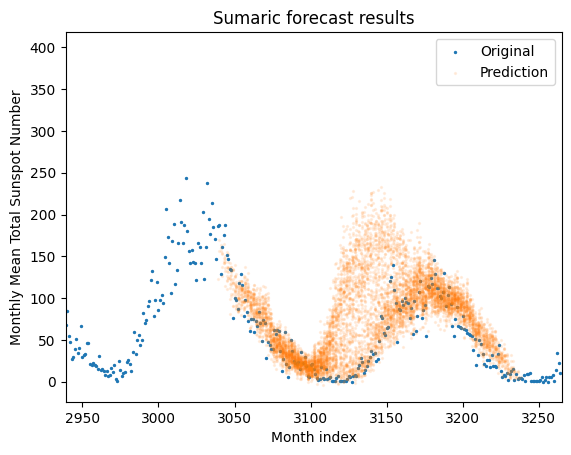

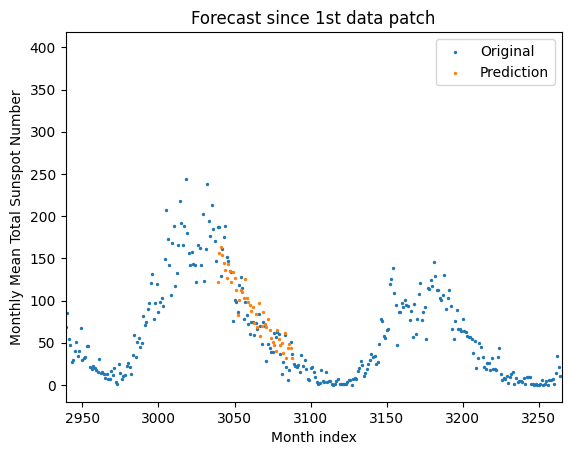

In [8]:
months_lim = (ds_sunspots_window.n_train(), ds_sunspots_window.n_values())
plot_forecasts(ds_sunspots_window.series_all, forecast_series, xlim=months_lim)
plot_forecast(ds_sunspots_window.series_all, forecast_series, 0, xlim=months_lim)

### Autoregression

In [9]:
forecast_ar = ar_forecast(ds_sunspots_ar.train_x, xgb_ar, ds_sunspots_ar.n_test())
forecast_series_ar = get_forecast_series_ar(forecast_ar, ds_sunspots_ar.n_train(), ds_sunspots_ar.n_test())

In [10]:
y_hat = forecast_series_ar
y = ds_sunspots_ar.series_all[forecast_series_ar.index]
err = y_hat - y

In [11]:
err

2939    -18.443873
2940    -27.151556
2941      4.760423
2942     20.693527
2943     26.293359
           ...    
3260    154.207953
3261    148.839136
3262    122.723694
3263    135.930270
3264    156.428003
Length: 326, dtype: float64

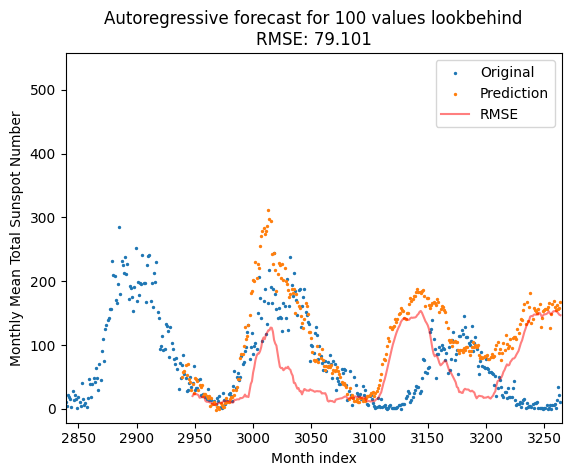

In [14]:
months_lim = (ds_sunspots_ar.n_train() - 100, ds_sunspots_ar.n_values())
plot_forecast_ar(ds_sunspots_ar.series_all, forecast_series_ar, months_lim, N_STEPS_IN_AR, metric_name="rmse")

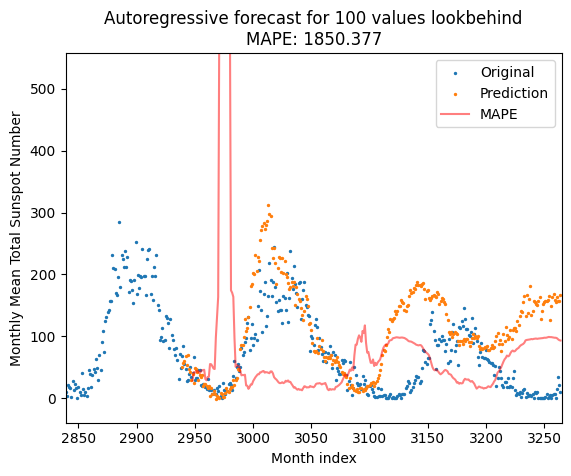

In [15]:
plot_forecast_ar(ds_sunspots_ar.series_all, forecast_series_ar, months_lim, N_STEPS_IN_AR, metric_name="mape")

477.84

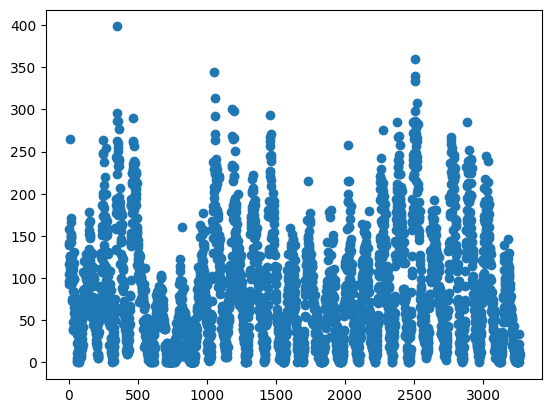

In [16]:
plt.scatter(ds_sunspots_ar.series_all.index, ds_sunspots_ar.series_all)
ds_sunspots_ar.series_all.max() * 1.2